# Introduction

This notebook shows how the molecular fingerprints and images used in `2.0-representing_data_as_images.ipynb` were generated. 

To run the notebook you must install `rdkit`: https://www.rdkit.org/docs/Install.html

The data from the source article 
> [1] https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0226-y 

is downloaded in the notebook from the direct link 

> https://static-content.springer.com/esm/art%3A10.1186%2Fs13321-017-0226-y/MediaObjects/13321_2017_226_MOESM2_ESM.zip

# Setup

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd
import shutil
import urllib

In [28]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [29]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'data'/'drug'
DATA.mkdir(exist_ok=True, parents=True)

RAWDATA = DATA/'raw'
RAWDATA.mkdir(exist_ok=True, parents=True)

INTERIMDATA = DATA/'interim'
INTERIMDATA.mkdir(exist_ok=True, parents=True)

# Location to store image files (change this as you see fit)
IMGDATA = Path('/data2/drugdiscovery/MOESM/molimages/')
IMGDATA.mkdir(exist_ok=True, parents=True)

# Get the data

In [30]:
list(DATA.iterdir())

[PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/interim')]

In [31]:
dataurl = 'https://static-content.springer.com/esm/art%3A10.1186%2Fs13321-017-0226-y/MediaObjects/13321_2017_226_MOESM1_ESM.zip'

In [32]:
fn, _ = urllib.request.urlretrieve(dataurl, DATA/'raw'/'13321_2017_226_MOESM1_ESM.zip')

In [33]:
shutil.unpack_archive(fn, extract_dir=DATA/'raw')

In [34]:
list(RAWDATA.iterdir())

[PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL301_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL1978_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL205_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL218_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL219_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL244_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/13321_2017_226_MOESM1_ESM.zip'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/RdkitD

In [35]:
datasets = sorted([d.stem for d in RAWDATA.glob('*.csv')])

In [36]:
datasets

['CHEMBL1978_cl',
 'CHEMBL205_cl',
 'CHEMBL218_cl',
 'CHEMBL219_cl',
 'CHEMBL240_cl',
 'CHEMBL244_cl',
 'CHEMBL301_cl']

In [39]:
pd.read_csv(next(RAWDATA.iterdir())).head()

CID                                             SMILES  Activity
0   CHEMBL310529  OCCS(=O)(=O)c1cc(c2ccc[nH]2)c3C(=O)Nc4ccc(F)c1c34         1
1   CHEMBL363069  Nc1nc2ccc(cn2c1C(=O)c3c(F)cc(O)cc3F)C(=O)c4c(C...         1
2  CHEMBL1081118  N[C@H](CCc1onc(n1)c2ccc3cnccc3c2)Cc4ccc(cc4)C(...         1
3   CHEMBL410883  NC(=O)c1ccc2NC(=O)\C(=N/Nc3ccc(cc3)S(=O)(=O)N)...         1
4  CHEMBL1081119  N[C@H](CNc1oc(nn1)c2ccc3cnccc3c2)Cc4ccc(cc4)C(...         1

# Get fingerprints

We compute the fingerprints in the same manner as in [1].

In [40]:
def get_fp(smile,diam=2,bits=1024,verbose=0):
    """
    Returns the fingerprint of the given smile, for the given diam and 
    number of bits.
    Returns an rdkit data structure (analogous to a list of booleans of length # bits)
    """
    mol = Chem.MolFromSmiles(smile)
    Chem.SanitizeMol(mol)
    fp=AllChem.GetMorganFingerprintAsBitVect(mol,diam,nBits=bits)
    
    if verbose:
        print(f"SMILE: {smile}")
        display(mol)
        
    return fp

SMILE: CNC(=O)[C@@H](NC(=O)N1C(=O)N(CCN2CCOCC2)c3ccccc13)C(C)(C)C


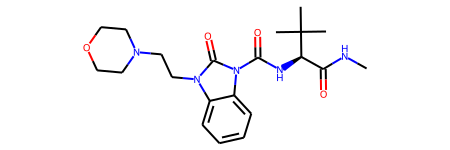

In [41]:
fp = get_fp(
            smile='CNC(=O)[C@@H](NC(=O)N1C(=O)N(CCN2CCOCC2)c3ccccc13)C(C)(C)C', 
            diam=2, 
            bits=1024, 
            verbose=1
            )

In [42]:
fp

In [43]:
def ECFP(ifile,ofile,diam,bits):
    """
    Generates circular fingerprints ECFP4 hashed into n bits length vectors
    Updated version of RdkitDescriptors.py. Works with Py3 (ASL)
    """
    
    print(f"Reading data from file {ifile}")
    df = pd.read_csv(ifile)    
    
    # FIX: The below can be sped up...#########
    # Insert the ECFP fingerprints in a new column
    df.insert(2, "ECFP4_", df.SMILES.apply(get_fp))
    # Split the column. Follow naming convention of RdkitDescriptors.py
    df[[f"ECFP4_{i+1}" for i in range(len(df.ECFP4_[0]))]] = df.ECFP4_.to_list()
    # Drop the now superfluous column
    df.drop("ECFP4_", axis=1, inplace=True)
    ###########################################
    
    
    df.to_csv(ofile, index=None)
    return df    

# Run on some data sets and store the results

In [44]:
INTERIMDATA

PosixPath('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/interim')

In [45]:
def get_fp_df(dataset, diam=2, bits=1024):
    infn = f'{RAWDATA/dataset}.csv'
    outfn = f'{INTERIMDATA/dataset}_ecfp_{bits}.csv'
    df = ECFP(infn, outfn, diam, bits)
    return df

In [46]:
datasets[0]

'CHEMBL1978_cl'

In [ ]:
df = get_fp_df(datasets[0])

In [47]:
df = pd.read_csv(INTERIMDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [48]:
df.head()

CID                                 SMILES  Activity  ECFP4_1  \
0  CHEMBL1454842            s1nc(nc1-c1ccncc1)-c1ccncc1         1        0   
1  CHEMBL1939366            s1nc(nc1-c1cccnc1)-c1cccnc1         1        0   
2   CHEMBL192155         s1cncc1\C=C\1/CCc2cc(OC)ccc/12         1        0   
3   CHEMBL517816  s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C         1        0   
4   CHEMBL523973  s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C         1        0   

   ECFP4_2  ECFP4_3  ECFP4_4  ECFP4_5  ECFP4_6  ECFP4_7  ...  ECFP4_1015  \
0        0        0        0        0        0        0  ...           0   
1        0        0        0        0        0        0  ...           0   
2        0        0        0        0        0        0  ...           0   
3        0        0        0        0        0        0  ...           0   
4        0        0        0        0        0        0  ...           0   

   ECFP4_1016  ECFP4_1017  ECFP4_1018  ECFP4_1019  ECFP4_1020  ECFP4_1021  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   ECFP4_1022  ECFP4_1023  ECFP4_1024  
0           0           0           0  
1           0           0           0  
2           0           0           0  
3           0           0           0  
4           0           0           0  

[5 rows x 1027 columns]

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


# Generate PNGs of molecular graphs

In [50]:
test_smile = df.loc[df.CID == 'CHEMBL1454842'].SMILES.values[0]
test_smile

's1nc(nc1-c1ccncc1)-c1ccncc1'

In [51]:
mol = Chem.MolFromSmiles(test_smile)

In [52]:
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

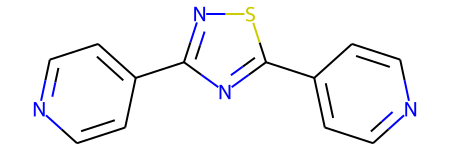

In [53]:
mol

# Create image representations for the seven bioactivity classes

1. CHEMBL205: Carbonic Anhydrase II, a protein lyase
2. CHEMBL301: Cyclin-dependent kinase 2, a protein kinase
3. CHEMNL240: ether-a-go-go-related gene potassium channel 1 (HERG)
4. CHEMBL219: Dopamine D4 receptor, a monoamine GPCR
5. CHEMBL244: Coagulation factor X, a serine protease
6. CHEMBL218: Cannabinoid CB1 receptor, a lipid-like GPCR
7. CHEMBL1978: Cytochrome P450 19A1, a cytochrome P450

In [54]:
def create_images(dataset, output_folder, size=(500,500), verbose=1):
    """
    Generate molecular drawings from the fingerprints in the input data 
    set using `rdkit`. Store the resulting images in `output_folder`.
    """
    output_folder = output_folder/dataset
    output_folder.mkdir(exist_ok=True)
    df = pd.read_csv(INTERIMDATA/f'{dataset}_ecfp_1024.csv')
    
    if verbose: 
        print(f"Processing {dataset}. {len(df)} images...")
        print(f"Outputs stored in {output_folder}")
        

    for idx, row in df.iterrows(): 
        cid = row.CID
        smile = row.SMILES
        mol = Chem.MolFromSmiles(smile)
        Chem.SanitizeMol(mol)
        Chem.Draw.MolToFile(mol, output_folder/f'{cid}.png', size=(500, 500), imageType="png")

In [ ]:
create_images(datasets[0], output_folder=IMGDATA, verbose=1)